In [1]:
import torch
from matplotlib import pyplot as plt

In [2]:
class torchIWT(torch.nn.Module):

    def __init__(self):
        super(torchIWT, self).__init__()

    def get_phi(self, x):
        # 拟Shannon小波
        mm = (3.2**2) * (1**2)
        t = torch.pi * x / 1
        ss = torch.sin(t)
        ee = torch.exp(-torch.square(x) / (2 * mm))
        out = (ss * ee) / t
        out[torch.where(t==0.)] = torch.tensor([1.])
        return out.cuda()

    def get_phi2d(self, xc, xr):
        return self.get_phi(xc) @ self.get_phi(xr).T

    def get_psi2d(self, j, kc, kr, xc, xr):
        return self.get_phi((2 ** (j+1)) * xc - (2*kc+1)) @ self.get_phi((2 ** (j+1)) * xr - (2*kr+1)).T
    
    def get_idx2d(self, xc, xr, x_transc, x_transr):
        diffc = torch.abs(xc - x_transc)
        idxc = torch.argmin(diffc)
        diffr = torch.abs(xr - x_transr)  # 查找插值基对应位置的索引
        idxr = torch.argmin(diffr)  # ...
        return [idxc, idxr]

    def func(self, img, xc, xr, x_transc, x_transr):
        idx = self.get_idx2d(xc, xr, x_transc, x_transr)
        return img[idx[0], idx[1]], idx

    def get_Iwt_l2d(self, imgl, xc, xr, j):
        Ijf = 0
        indicies = []
        for kc in range(-2 ** j, 2 ** j + 1, 1):
            for kr in range(-2 ** j, 2 ** j + 1, 1):
                phi_jk = self.get_phi2d((2 ** j) * xc-kc, (2 ** j) * xr-kr)
                x_jkc, x_jkr = kc * (2 ** (-j)), kr * (2 ** (-j))
                f_xjk, idx = self.func(imgl, xc, xr, x_jkc, x_jkr)
                Ijf += f_xjk * phi_jk
                indicies.append(idx)
        return Ijf, [indicies]
    
    def get_Iwt2d(self, img, xc, xr, j0, J, e):
        approx, indicies = self.get_Iwt_l2d(img, xc, xr, j0)  # 逼近结果
        if J <= j0:
            return approx, indicies

        for j in range(j0, J):
            idxs = []
            details = torch.zeros_like(approx)
            for kc in torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5):
                for kr in torch.arange((-2 ** (j+1)-1) / 2, 2 ** (j+1)/2, 0.5):
                    alpha_jk, idx = self.get_alpha_jk2d(img, xc, xr, j, kc, kr, approx, th=e)
                    if (idx[0] + idx[1]) > 0:
                        idxs.append(idx)
                    psi_jk = self.get_psi2d(j, kc, kr, xc, xr)
                    details += (alpha_jk * psi_jk)
            approx = approx + details
            indicies.append(idxs)
        return approx, indicies

    def get_alpha_jk2d(self, img, xc, xr, j, kc, kr, u, th):
        x_jkc, x_jkr = (2*kc+1) * (2 ** (-j-1)), (2*kr+1) * (2 ** (-j-1))  # 插值基位置
        f_yjk, idx = self.func(img, xc, xr, x_jkc, x_jkr)  # 插值基对应待逼近函数点值
        diff = torch.abs(f_yjk - u[idx[0], idx[1]])
        if diff > th:
            return f_yjk - u[idx[0], idx[1]], idx
        else:
            return 0, [0, 0]

In [3]:
import numpy as np

In [4]:
def show_approx(imgl, approx, indicies, level_points, s=5, cmap='jet', show_2d_points=True, al=0.5):
    xa = np.arange(approx.shape[0])
    ya = np.arange(approx.shape[1])
    xaa, yaa = np.meshgrid(xa, ya)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xaa, yaa, approx.T, cmap='jet', alpha=al)

    idxnp = []
    if level_points == -1 or level_points >= len(indicies):
        for i in indicies:
            idxnp = idxnp + i
    else:
        idxnp = indicies[level_points]
        
    idxs = np.array(idxnp)
    idxsu = np.unique(idxs, axis=0).T
    idxsut = (idxsu[1,:], idxsu[0,:])
    ax.scatter(xaa[idxsut], yaa[idxsut], approx.T[idxsut], color='black', marker='o', s=2*s)

    ax.set_title('points_num: {}'.format(len(idxnp)))

    plt.figure()
    fig, axs = plt.subplots(1,2)
    axs[0].imshow(approx, cmap=cmap)
    axs[0].set_title('approx_img')
    axs[1].imshow(imgl, cmap=cmap)
    axs[1].set_title('raw_img')
    if show_2d_points:
        if cmap == 'gray':
            color = 'red'
        else:
            color = 'black'
        points = list(zip(idxsut[0], idxsut[1]))
        x1, y1 = zip(*points)
        axs[1].scatter(x1, y1, color=color, s=s)

    plt.show()


def show_3d_points(approx, indicies, level_points=2):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    indicieslevel = len(indicies)
    if level_points == -1 or level_points >= len(indicies):
        pass
    else:
        indicies = [indicies[level_points]]
    for idx, i in enumerate(indicies):
        i = np.array(i)
        idxsu = np.unique(i, axis=0).T
        if len(idxsu) == 0:
            continue
        idxsut = (idxsu[1,:], idxsu[0,:])
        xa = np.arange(approx.shape[0])
        ya = np.arange(approx.shape[1])
        xaa, yaa = np.meshgrid(xa, ya)
        amm = np.zeros_like(approx)
        if level_points == -1 or level_points >= indicieslevel:
            d = idx
        else:
            d = level_points
        amm[i[:,0], i[:,1]] = d
        ax.set_xlim([0, approx.shape[0]])
        ax.set_ylim([0, approx.shape[1]])
        ax.set_zlim([0, indicieslevel])
        ax.scatter(xaa[idxsut], yaa[idxsut], amm.T[idxsut], marker='o', s=(indicieslevel-idx+1)*5)
    plt.show()

In [5]:
xc = torch.arange(-1,1,1/256).reshape((-1,1)).cuda()
xr = xc.clone()
imgl = torch.sin(2*xc).reshape((-1,1)) @ torch.cos(5*xr).reshape((1,-1))
imgl = imgl.cuda()

xc = torch.arange(-1, 1, 2/imgl.shape[0]).reshape((-1,1))
xr = torch.arange(-1, 1, 2/imgl.shape[1]).reshape((-1,1))

In [6]:
j0 = 0
J = 5
e = 0.01

iwtmodel = torchIWT()
iwtmodel.cuda()

approx, indicies = iwtmodel.get_Iwt2d(imgl, xc, xr, j0, J, e)

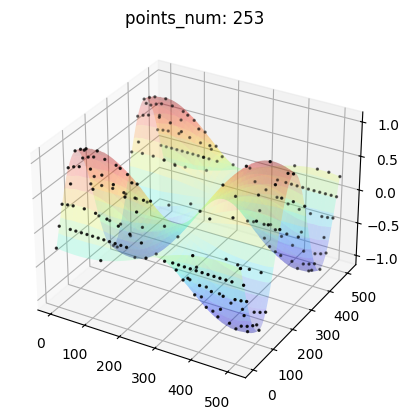

<Figure size 640x480 with 0 Axes>

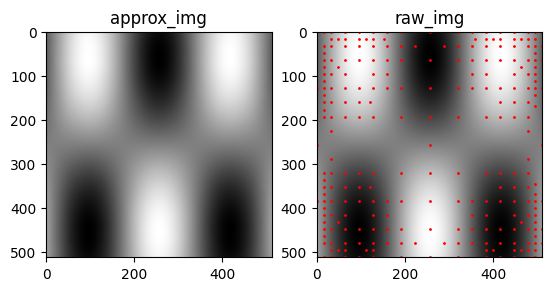

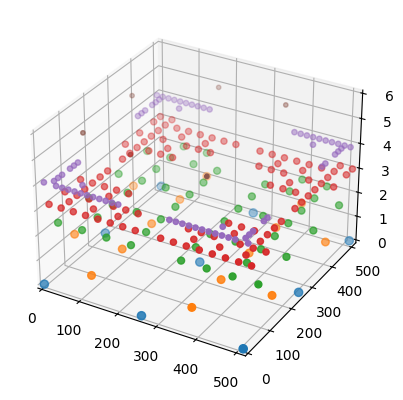

In [7]:
l=-1
show_approx(imgl.cpu(), approx.cpu(), indicies, level_points=-1, s=1, cmap='gray', show_2d_points=True, al=0.2)
show_3d_points(approx.cpu(), indicies, level_points=l)

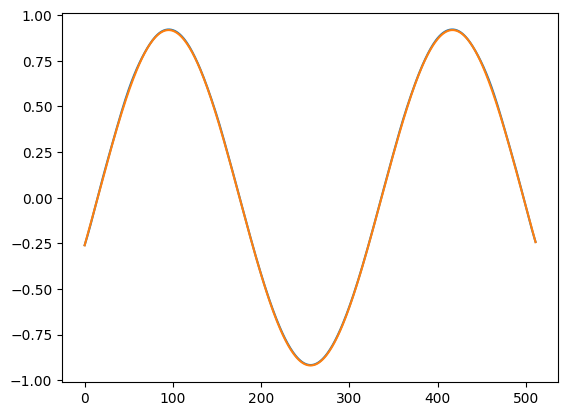

In [8]:
plt.plot(approx.cpu()[3,:])
plt.plot(imgl.cpu()[3,:])

In [9]:
indicies

[[[tensor(0), tensor(0)],
  [tensor(0), tensor(256)],
  [tensor(0), tensor(511)],
  [tensor(256), tensor(0)],
  [tensor(256), tensor(256)],
  [tensor(256), tensor(511)],
  [tensor(511), tensor(0)],
  [tensor(511), tensor(256)],
  [tensor(511), tensor(511)]],
 [[tensor(0), tensor(128)],
  [tensor(0), tensor(384)],
  [tensor(128), tensor(0)],
  [tensor(128), tensor(128)],
  [tensor(128), tensor(256)],
  [tensor(128), tensor(384)],
  [tensor(128), tensor(511)],
  [tensor(384), tensor(0)],
  [tensor(384), tensor(128)],
  [tensor(384), tensor(256)],
  [tensor(384), tensor(384)],
  [tensor(384), tensor(511)],
  [tensor(511), tensor(128)],
  [tensor(511), tensor(384)]],
 [[tensor(0), tensor(64)],
  [tensor(0), tensor(192)],
  [tensor(0), tensor(320)],
  [tensor(0), tensor(448)],
  [tensor(64), tensor(64)],
  [tensor(64), tensor(128)],
  [tensor(64), tensor(192)],
  [tensor(64), tensor(256)],
  [tensor(64), tensor(320)],
  [tensor(64), tensor(384)],
  [tensor(64), tensor(448)],
  [tensor(64), 